# Simple AUTOENCODER for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [61]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
#from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython', '/home/rgadea/lmfit-py/', '/home/rgadea/lmfit-py/', '/home/rgadea/lmfit-py/', '/home/rgadea/lmfit-py/']


## Vamos introducir los datos de petalo preprocesados en matlab


In [62]:
import scipy.io as sio
import hdf5storage
datos_matlab = hdf5storage.loadmat('../datos_octubre_2018/conjunto_entrenamiento_octubre_2018_red_pitch5mm_rad161mm_total.mat')
conjunto_datos= datos_matlab.get('photodefA')
conjunto_datos.shape

(66498, 640)

In [63]:
import os
import pandas as pd
dir_name='../datos_octubre_2018'
base_filename='p_OF_5mm_161mm'
filename_suffix='.h5'
file=os.path.join(dir_name, base_filename+ "{0:03d}".format(0) + filename_suffix)
conjunto_datos_waves=pd.read_hdf(file,'MC')
datos_waves=conjunto_datos_waves.values
datos_waves.shape

(6320, 3840)

In [64]:
for i in range(1,2):
    file=os.path.join(dir_name, base_filename+ "{0:03d}".format(i) + filename_suffix)
    #print(file)
    veamos=pd.read_hdf(file,'MC')
    veamos_array=veamos.values
    datos_waves=np.concatenate((datos_waves,veamos_array),axis=0)
datos_waves.shape

(12641, 3840)

In [65]:
L1A=6;
# hay tres L1 con 640 sensores (40*16)
# input image dimensions
img_rows, img_cols = 16, 40

X_trained=datos_waves;
x_trained=X_trained;

for i in range (X_trained.shape[0]):
    idea1=X_trained[i,:].reshape(img_rows,(L1A*img_cols));
    ideat=idea1.transpose();
    idea2=ideat.reshape(1,(L1A*img_cols)*img_rows);
    x_trained[i,:] =idea2;

print(x_trained.shape)


(12641, 3840)


In [66]:
input_output_dim_A=img_rows*img_cols
ideaA=np.zeros((L1A,input_output_dim_A))

conjunto_datos=np.zeros((x_trained.shape[0]*L1A,input_output_dim_A))
for i in range(x_trained.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_trained[i,k*input_output_dim_A:k*input_output_dim_A+input_output_dim_A]
    conjunto_datos[(i)*L1A :(i+1)*L1A,:] = ideaA    
    

  

## Network parameters:

In [67]:
use_regularizer = True
my_regularizer = None
my_epochs = 50
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l2(0.001)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'

   
    
encoding_dim = 320  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


# this is our input placeholder

input_img = Input(shape=(img_rows*img_cols,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='sigmoid', use_bias=False,bias_initializer='random_uniform')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(img_cols*img_rows, activation='sigmoid',use_bias=True,bias_initializer='random_uniform')(encoded)

# this model maps an input to its reconstruction


#autoencoder=Sequential([
#    Dense(encoding_dim, kernel_regularizer=regularizers.l2(0.001), use_bias=True,bias_initializer='random_uniform',input_shape=(640,)),
#    Activation('sigmoid'),
#    Dense(img_cols*img_rows, use_bias=True,bias_initializer='random_uniform'),
#    Activation('linear'),
#])

autoencoder = Model(input_img, decoded)

## Prepare data into training and test set.

In [68]:
# the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)

tr_size=60
val_size=20
test_size=100-val_size-tr_size

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


X_train=conjunto_datos[:tamanyo_tr,:]
X_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,:]
X_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,:]





Y_train=conjunto_datos[:tamanyo_tr,1] #elijo la coordenada radius
Y_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,1] #elijo la corrdenada radius
Y_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,1] #elijo la corrdenada radius

75846
conjunto_datos shape: (75846, 640)
45507
15169
15170


In [69]:
X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows,1)
X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows,1)
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows,1)


input_shape = (img_cols, img_rows,1)
#input_shape=input_shape.astype('int32')

In [70]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (45507, 40, 16, 1)
45507 train samples
15169 validation samples
15170 test samples


Display 20 random training images using image

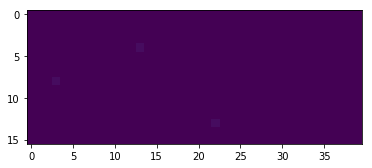

40398


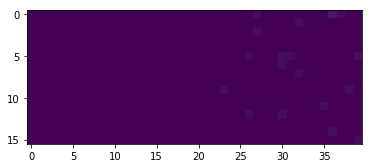

19094


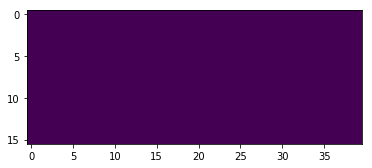

22017


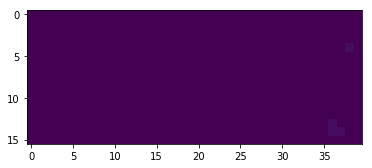

17858


In [71]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [16, 40]), vmin=0, vmax=30)
    plt.viridis()
    plt.show()
    print(idea)

Vamos a generar las matrices de datos para la red neuronal 

In [72]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
prueba=x_train[0:15170,:]
print(x_train.shape)
print(x_test.shape)
print(prueba.shape)

(45507, 640)
(15170, 640)
(15170, 640)


In [73]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
#min_max_scaler = preprocessing.RobustScaler().fit(x_train)
supermax=100
print(min_max_scaler)
#x_train_scaled = min_max_scaler.transform(x_train)
#x_test_scaled = min_max_scaler.transform(x_test)
x_train_scaled=x_train/supermax
x_test_scaled=x_test/supermax
#min_max_scaler.scale_
x_train[29413]
x_train_scaled[29413]

MinMaxScaler(copy=True, feature_range=(0, 1))


array([0.01, 0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.03, 0.  , 0.04, 0.02,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02,
       0.03, 0.04, 0.01, 0.  , 0.02, 0.01, 0.02, 0.01, 0.02, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.02, 0.  , 0.04, 0.05, 0.04, 0.01, 0.  , 0.  ,
       0.01, 0.01, 0.02, 0.01, 0.  , 0.  , 0.01, 0.  , 0.01, 0.02, 0.03,
       0.02, 0.01, 0.  , 0.04, 0.04, 0.04, 0.  , 0.01, 0.01, 0.01, 0.  ,
       0.01, 0.  , 0.01, 0.03, 0.01, 0.01, 0.02, 0.01, 0.02, 0.03, 0.01,
       0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.02, 0.02, 0.01,
       0.03, 0.04, 0.03, 0.03, 0.01, 0.03, 0.  , 0.02, 0.  , 0.  , 0.01,
       0.  , 0.  , 0.02, 0.01, 0.02, 0.01, 0.02, 0.  , 0.03, 0.02, 0.01,
       0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.03, 0.02,
       0.01, 0.  , 0.01, 0.03, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.01,
       0.02, 0.  , 0.  , 0.01, 0.04, 0.02, 0.  , 0.01, 0.01, 0.  , 0.  ,
       0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.

## Build the autoencoder. 

In [74]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='RMSprop', loss='mse')



Show a summary of the model parameters. 

And now train the model and evaluate on the test set. 

In [75]:
algoritmo='rmsprop'
experimento="scaled_100_without_encoder_bias"
tensorboard=TensorBoard(log_dir="/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/{}{}{}".format(algoritmo,experimento,time()))
#modelCheckpoint=ModelCheckpoint("/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=2, mode='auto', baseline=None)
autoencoder.fit(x_train_scaled, x_train_scaled,
                epochs=5000,
                batch_size=200,
                shuffle=False,
                callbacks=[tensorboard, early_stop],
                validation_data=(x_test_scaled, x_test_scaled))



Train on 45507 samples, validate on 15170 samples
Epoch 1/5000
45507/45507 [==============================] - 1s 30us/step - loss: 0.0051 - val_loss: 2.9891e-04
Epoch 2/5000
45507/45507 [==============================] - 1s 25us/step - loss: 3.4067e-04 - val_loss: 2.9818e-04
Epoch 3/5000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4044e-04 - val_loss: 2.9811e-04
Epoch 4/5000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4040e-04 - val_loss: 2.9810e-04
Epoch 5/5000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4039e-04 - val_loss: 2.9809e-04
Epoch 6/5000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4038e-04 - val_loss: 2.9808e-04
Epoch 7/5000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4037e-04 - val_loss: 2.9807e-04
Epoch 8/5000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4037e-04 - val_loss: 2.9807e-04
Epoch 9/5000
45507/45507 [========

45507/45507 [==============================] - 2s 36us/step - loss: 3.3711e-04 - val_loss: 2.9739e-04
Epoch 72/5000
45507/45507 [==============================] - 2s 37us/step - loss: 3.3691e-04 - val_loss: 2.9737e-04
Epoch 73/5000
45507/45507 [==============================] - 1s 32us/step - loss: 3.3671e-04 - val_loss: 2.9735e-04
Epoch 74/5000
45507/45507 [==============================] - 2s 37us/step - loss: 3.3649e-04 - val_loss: 2.9733e-04
Epoch 75/5000
45507/45507 [==============================] - 2s 37us/step - loss: 3.3628e-04 - val_loss: 2.9731e-04
Epoch 76/5000
45507/45507 [==============================] - 2s 33us/step - loss: 3.3607e-04 - val_loss: 2.9729e-04
Epoch 77/5000
45507/45507 [==============================] - 2s 37us/step - loss: 3.3586e-04 - val_loss: 2.9727e-04
Epoch 78/5000
45507/45507 [==============================] - 2s 36us/step - loss: 3.3566e-04 - val_loss: 2.9724e-04
Epoch 79/5000
45507/45507 [==============================] - 2s 33us/step - loss: 3.35

45507/45507 [==============================] - 2s 34us/step - loss: 3.2056e-04 - val_loss: 2.9211e-04
Epoch 142/5000
45507/45507 [==============================] - 2s 36us/step - loss: 3.2003e-04 - val_loss: 2.9183e-04
Epoch 143/5000
45507/45507 [==============================] - 2s 36us/step - loss: 3.1946e-04 - val_loss: 2.9154e-04
Epoch 144/5000
45507/45507 [==============================] - 2s 36us/step - loss: 3.1886e-04 - val_loss: 2.9123e-04
Epoch 145/5000
45507/45507 [==============================] - 2s 36us/step - loss: 3.1823e-04 - val_loss: 2.9089e-04
Epoch 146/5000
45507/45507 [==============================] - 2s 36us/step - loss: 3.1756e-04 - val_loss: 2.9053e-04
Epoch 147/5000
45507/45507 [==============================] - 2s 36us/step - loss: 3.1685e-04 - val_loss: 2.9014e-04
Epoch 148/5000
45507/45507 [==============================] - 2s 36us/step - loss: 3.1610e-04 - val_loss: 2.8971e-04
Epoch 149/5000
45507/45507 [==============================] - 2s 36us/step - lo

45507/45507 [==============================] - 2s 36us/step - loss: 2.4827e-04 - val_loss: 2.3882e-04
Epoch 212/5000
45507/45507 [==============================] - 2s 36us/step - loss: 2.4720e-04 - val_loss: 2.3800e-04
Epoch 213/5000
45507/45507 [==============================] - 2s 37us/step - loss: 2.4613e-04 - val_loss: 2.3718e-04
Epoch 214/5000
45507/45507 [==============================] - 1s 32us/step - loss: 2.4507e-04 - val_loss: 2.3637e-04
Epoch 215/5000
45507/45507 [==============================] - 2s 36us/step - loss: 2.4403e-04 - val_loss: 2.3556e-04
Epoch 216/5000
45507/45507 [==============================] - 2s 36us/step - loss: 2.4299e-04 - val_loss: 2.3476e-04
Epoch 217/5000
45507/45507 [==============================] - 2s 36us/step - loss: 2.4195e-04 - val_loss: 2.3396e-04
Epoch 218/5000
45507/45507 [==============================] - 2s 33us/step - loss: 2.4093e-04 - val_loss: 2.3317e-04
Epoch 219/5000
45507/45507 [==============================] - 2s 37us/step - lo

45507/45507 [==============================] - 2s 36us/step - loss: 1.9641e-04 - val_loss: 1.9719e-04
Epoch 282/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.9597e-04 - val_loss: 1.9677e-04
Epoch 283/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.9553e-04 - val_loss: 1.9636e-04
Epoch 284/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.9510e-04 - val_loss: 1.9595e-04
Epoch 285/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.9468e-04 - val_loss: 1.9555e-04
Epoch 286/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.9426e-04 - val_loss: 1.9515e-04
Epoch 287/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.9385e-04 - val_loss: 1.9475e-04
Epoch 288/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.9344e-04 - val_loss: 1.9436e-04
Epoch 289/5000
45507/45507 [==============================] - 2s 36us/step - lo

45507/45507 [==============================] - 2s 36us/step - loss: 1.7380e-04 - val_loss: 1.7495e-04
Epoch 352/5000
45507/45507 [==============================] - 2s 33us/step - loss: 1.7358e-04 - val_loss: 1.7471e-04
Epoch 353/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.7335e-04 - val_loss: 1.7447e-04
Epoch 354/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.7313e-04 - val_loss: 1.7423e-04
Epoch 355/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.7291e-04 - val_loss: 1.7399e-04
Epoch 356/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.7270e-04 - val_loss: 1.7375e-04
Epoch 357/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.7248e-04 - val_loss: 1.7351e-04
Epoch 358/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.7227e-04 - val_loss: 1.7327e-04
Epoch 359/5000
45507/45507 [==============================] - 2s 36us/step - lo

45507/45507 [==============================] - 1s 33us/step - loss: 1.6187e-04 - val_loss: 1.6100e-04
Epoch 422/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.6174e-04 - val_loss: 1.6085e-04
Epoch 423/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.6162e-04 - val_loss: 1.6070e-04
Epoch 424/5000
45507/45507 [==============================] - 1s 27us/step - loss: 1.6150e-04 - val_loss: 1.6055e-04
Epoch 425/5000
45507/45507 [==============================] - 1s 32us/step - loss: 1.6137e-04 - val_loss: 1.6040e-04
Epoch 426/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.6125e-04 - val_loss: 1.6025e-04
Epoch 427/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.6113e-04 - val_loss: 1.6010e-04
Epoch 428/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.6101e-04 - val_loss: 1.5995e-04
Epoch 429/5000
45507/45507 [==============================] - 2s 36us/step - lo

45507/45507 [==============================] - 2s 37us/step - loss: 1.5493e-04 - val_loss: 1.5242e-04
Epoch 492/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.5486e-04 - val_loss: 1.5232e-04
Epoch 493/5000
45507/45507 [==============================] - 1s 31us/step - loss: 1.5478e-04 - val_loss: 1.5222e-04
Epoch 494/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.5471e-04 - val_loss: 1.5212e-04
Epoch 495/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.5463e-04 - val_loss: 1.5202e-04
Epoch 496/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.5456e-04 - val_loss: 1.5192e-04
Epoch 497/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.5449e-04 - val_loss: 1.5182e-04
Epoch 498/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.5441e-04 - val_loss: 1.5172e-04
Epoch 499/5000
45507/45507 [==============================] - 1s 29us/step - lo

45507/45507 [==============================] - 2s 36us/step - loss: 1.5074e-04 - val_loss: 1.4670e-04
Epoch 562/5000
45507/45507 [==============================] - 2s 33us/step - loss: 1.5069e-04 - val_loss: 1.4664e-04
Epoch 563/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.5065e-04 - val_loss: 1.4657e-04
Epoch 564/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.5060e-04 - val_loss: 1.4651e-04
Epoch 565/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.5056e-04 - val_loss: 1.4645e-04
Epoch 566/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.5051e-04 - val_loss: 1.4639e-04
Epoch 567/5000
45507/45507 [==============================] - 1s 28us/step - loss: 1.5047e-04 - val_loss: 1.4633e-04
Epoch 568/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.5043e-04 - val_loss: 1.4627e-04
Epoch 569/5000
45507/45507 [==============================] - 2s 37us/step - lo

45507/45507 [==============================] - 2s 34us/step - loss: 1.4821e-04 - val_loss: 1.4315e-04
Epoch 632/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4818e-04 - val_loss: 1.4311e-04
Epoch 633/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4815e-04 - val_loss: 1.4307e-04
Epoch 634/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4812e-04 - val_loss: 1.4303e-04
Epoch 635/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4809e-04 - val_loss: 1.4299e-04
Epoch 636/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4807e-04 - val_loss: 1.4295e-04
Epoch 637/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4804e-04 - val_loss: 1.4291e-04
Epoch 638/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4801e-04 - val_loss: 1.4287e-04
Epoch 639/5000
45507/45507 [==============================] - 2s 37us/step - lo

45507/45507 [==============================] - 2s 35us/step - loss: 1.4659e-04 - val_loss: 1.4080e-04
Epoch 702/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4657e-04 - val_loss: 1.4077e-04
Epoch 703/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4655e-04 - val_loss: 1.4075e-04
Epoch 704/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4653e-04 - val_loss: 1.4072e-04
Epoch 705/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.4651e-04 - val_loss: 1.4069e-04
Epoch 706/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4649e-04 - val_loss: 1.4066e-04
Epoch 707/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4648e-04 - val_loss: 1.4064e-04
Epoch 708/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4646e-04 - val_loss: 1.4061e-04
Epoch 709/5000
45507/45507 [==============================] - 2s 37us/step - lo

45507/45507 [==============================] - 2s 37us/step - loss: 1.4543e-04 - val_loss: 1.3909e-04
Epoch 772/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4542e-04 - val_loss: 1.3907e-04
Epoch 773/5000
45507/45507 [==============================] - 1s 32us/step - loss: 1.4540e-04 - val_loss: 1.3905e-04
Epoch 774/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4539e-04 - val_loss: 1.3902e-04
Epoch 775/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4538e-04 - val_loss: 1.3900e-04
Epoch 776/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4536e-04 - val_loss: 1.3898e-04
Epoch 777/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4535e-04 - val_loss: 1.3896e-04
Epoch 778/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4534e-04 - val_loss: 1.3894e-04
Epoch 779/5000
45507/45507 [==============================] - 1s 33us/step - lo

45507/45507 [==============================] - 2s 37us/step - loss: 1.4458e-04 - val_loss: 1.3774e-04
Epoch 842/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.4457e-04 - val_loss: 1.3772e-04
Epoch 843/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4456e-04 - val_loss: 1.3770e-04
Epoch 844/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4455e-04 - val_loss: 1.3768e-04
Epoch 845/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4454e-04 - val_loss: 1.3767e-04
Epoch 846/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4453e-04 - val_loss: 1.3765e-04
Epoch 847/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4452e-04 - val_loss: 1.3763e-04
Epoch 848/5000
45507/45507 [==============================] - 1s 29us/step - loss: 1.4451e-04 - val_loss: 1.3762e-04
Epoch 849/5000
45507/45507 [==============================] - 2s 36us/step - lo

45507/45507 [==============================] - 2s 35us/step - loss: 1.4391e-04 - val_loss: 1.3663e-04
Epoch 912/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4390e-04 - val_loss: 1.3662e-04
Epoch 913/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4389e-04 - val_loss: 1.3660e-04
Epoch 914/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4388e-04 - val_loss: 1.3659e-04
Epoch 915/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4387e-04 - val_loss: 1.3657e-04
Epoch 916/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4386e-04 - val_loss: 1.3656e-04
Epoch 917/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4385e-04 - val_loss: 1.3654e-04
Epoch 918/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4385e-04 - val_loss: 1.3653e-04
Epoch 919/5000
45507/45507 [==============================] - 2s 36us/step - lo

45507/45507 [==============================] - 2s 35us/step - loss: 1.4338e-04 - val_loss: 1.3570e-04
Epoch 982/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4337e-04 - val_loss: 1.3568e-04
Epoch 983/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4336e-04 - val_loss: 1.3567e-04
Epoch 984/5000
45507/45507 [==============================] - 2s 33us/step - loss: 1.4336e-04 - val_loss: 1.3566e-04
Epoch 985/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.4335e-04 - val_loss: 1.3565e-04
Epoch 986/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4334e-04 - val_loss: 1.3563e-04
Epoch 987/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4334e-04 - val_loss: 1.3562e-04
Epoch 988/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4333e-04 - val_loss: 1.3561e-04
Epoch 989/5000
45507/45507 [==============================] - 2s 36us/step - lo

45507/45507 [==============================] - 2s 36us/step - loss: 1.4296e-04 - val_loss: 1.3490e-04
Epoch 1051/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4295e-04 - val_loss: 1.3489e-04
Epoch 1052/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4294e-04 - val_loss: 1.3488e-04
Epoch 1053/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.4294e-04 - val_loss: 1.3487e-04
Epoch 1054/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.4293e-04 - val_loss: 1.3486e-04
Epoch 1055/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4293e-04 - val_loss: 1.3485e-04
Epoch 1056/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4292e-04 - val_loss: 1.3484e-04
Epoch 1057/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4292e-04 - val_loss: 1.3483e-04
Epoch 1058/5000
45507/45507 [==============================] - 2s 37us/s

45507/45507 [==============================] - 2s 34us/step - loss: 1.4260e-04 - val_loss: 1.3420e-04
Epoch 1120/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4259e-04 - val_loss: 1.3419e-04
Epoch 1121/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4259e-04 - val_loss: 1.3418e-04
Epoch 1122/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4258e-04 - val_loss: 1.3417e-04
Epoch 1123/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4258e-04 - val_loss: 1.3416e-04
Epoch 1124/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4257e-04 - val_loss: 1.3415e-04
Epoch 1125/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4257e-04 - val_loss: 1.3414e-04
Epoch 1126/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4257e-04 - val_loss: 1.3413e-04
Epoch 1127/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 35us/step - loss: 1.4229e-04 - val_loss: 1.3356e-04
Epoch 1189/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4229e-04 - val_loss: 1.3355e-04
Epoch 1190/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4228e-04 - val_loss: 1.3354e-04
Epoch 1191/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.4228e-04 - val_loss: 1.3353e-04
Epoch 1192/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4227e-04 - val_loss: 1.3352e-04
Epoch 1193/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4227e-04 - val_loss: 1.3351e-04
Epoch 1194/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4227e-04 - val_loss: 1.3350e-04
Epoch 1195/5000
45507/45507 [==============================] - 2s 33us/step - loss: 1.4226e-04 - val_loss: 1.3349e-04
Epoch 1196/5000
45507/45507 [==============================] - 2s 34us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.4202e-04 - val_loss: 1.3297e-04
Epoch 1258/5000
45507/45507 [==============================] - 1s 32us/step - loss: 1.4202e-04 - val_loss: 1.3296e-04
Epoch 1259/5000
45507/45507 [==============================] - 2s 33us/step - loss: 1.4201e-04 - val_loss: 1.3296e-04
Epoch 1260/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4201e-04 - val_loss: 1.3295e-04
Epoch 1261/5000
45507/45507 [==============================] - 2s 33us/step - loss: 1.4201e-04 - val_loss: 1.3294e-04
Epoch 1262/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4200e-04 - val_loss: 1.3293e-04
Epoch 1263/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4200e-04 - val_loss: 1.3292e-04
Epoch 1264/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.4199e-04 - val_loss: 1.3291e-04
Epoch 1265/5000
45507/45507 [==============================] - 2s 33us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.4178e-04 - val_loss: 1.3243e-04
Epoch 1327/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4178e-04 - val_loss: 1.3242e-04
Epoch 1328/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4177e-04 - val_loss: 1.3242e-04
Epoch 1329/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4177e-04 - val_loss: 1.3241e-04
Epoch 1330/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4177e-04 - val_loss: 1.3240e-04
Epoch 1331/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4176e-04 - val_loss: 1.3239e-04
Epoch 1332/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4176e-04 - val_loss: 1.3239e-04
Epoch 1333/5000
45507/45507 [==============================] - 1s 28us/step - loss: 1.4176e-04 - val_loss: 1.3238e-04
Epoch 1334/5000
45507/45507 [==============================] - 2s 37us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.4156e-04 - val_loss: 1.3193e-04
Epoch 1396/5000
45507/45507 [==============================] - 1s 27us/step - loss: 1.4156e-04 - val_loss: 1.3192e-04
Epoch 1397/5000
45507/45507 [==============================] - 1s 30us/step - loss: 1.4156e-04 - val_loss: 1.3192e-04
Epoch 1398/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4156e-04 - val_loss: 1.3191e-04
Epoch 1399/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4155e-04 - val_loss: 1.3190e-04
Epoch 1400/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4155e-04 - val_loss: 1.3190e-04
Epoch 1401/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4155e-04 - val_loss: 1.3189e-04
Epoch 1402/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4154e-04 - val_loss: 1.3188e-04
Epoch 1403/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 37us/step - loss: 1.4137e-04 - val_loss: 1.3146e-04
Epoch 1465/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4137e-04 - val_loss: 1.3146e-04
Epoch 1466/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4136e-04 - val_loss: 1.3145e-04
Epoch 1467/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4136e-04 - val_loss: 1.3144e-04
Epoch 1468/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4136e-04 - val_loss: 1.3144e-04
Epoch 1469/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.4136e-04 - val_loss: 1.3143e-04
Epoch 1470/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4135e-04 - val_loss: 1.3143e-04
Epoch 1471/5000
45507/45507 [==============================] - 1s 28us/step - loss: 1.4135e-04 - val_loss: 1.3142e-04
Epoch 1472/5000
45507/45507 [==============================] - 1s 28us/s

45507/45507 [==============================] - 2s 37us/step - loss: 1.4119e-04 - val_loss: 1.3103e-04
Epoch 1534/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.4119e-04 - val_loss: 1.3102e-04
Epoch 1535/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4118e-04 - val_loss: 1.3101e-04
Epoch 1536/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4118e-04 - val_loss: 1.3101e-04
Epoch 1537/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4118e-04 - val_loss: 1.3100e-04
Epoch 1538/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4118e-04 - val_loss: 1.3099e-04
Epoch 1539/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4117e-04 - val_loss: 1.3099e-04
Epoch 1540/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4117e-04 - val_loss: 1.3098e-04
Epoch 1541/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.4103e-04 - val_loss: 1.3061e-04
Epoch 1603/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4102e-04 - val_loss: 1.3060e-04
Epoch 1604/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4102e-04 - val_loss: 1.3060e-04
Epoch 1605/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4102e-04 - val_loss: 1.3059e-04
Epoch 1606/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4102e-04 - val_loss: 1.3059e-04
Epoch 1607/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4101e-04 - val_loss: 1.3058e-04
Epoch 1608/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4101e-04 - val_loss: 1.3058e-04
Epoch 1609/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4101e-04 - val_loss: 1.3057e-04
Epoch 1610/5000
45507/45507 [==============================] - 2s 35us/s

45507/45507 [==============================] - 2s 37us/step - loss: 1.4087e-04 - val_loss: 1.3021e-04
Epoch 1672/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4087e-04 - val_loss: 1.3021e-04
Epoch 1673/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4087e-04 - val_loss: 1.3020e-04
Epoch 1674/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.4087e-04 - val_loss: 1.3019e-04
Epoch 1675/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4086e-04 - val_loss: 1.3019e-04
Epoch 1676/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4086e-04 - val_loss: 1.3018e-04
Epoch 1677/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4086e-04 - val_loss: 1.3018e-04
Epoch 1678/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4086e-04 - val_loss: 1.3017e-04
Epoch 1679/5000
45507/45507 [==============================] - 2s 34us/s

45507/45507 [==============================] - 2s 37us/step - loss: 1.4073e-04 - val_loss: 1.2980e-04
Epoch 1741/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4073e-04 - val_loss: 1.2979e-04
Epoch 1742/5000
45507/45507 [==============================] - 1s 31us/step - loss: 1.4073e-04 - val_loss: 1.2979e-04
Epoch 1743/5000
45507/45507 [==============================] - 1s 30us/step - loss: 1.4072e-04 - val_loss: 1.2978e-04
Epoch 1744/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4072e-04 - val_loss: 1.2978e-04
Epoch 1745/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4072e-04 - val_loss: 1.2977e-04
Epoch 1746/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4072e-04 - val_loss: 1.2976e-04
Epoch 1747/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4072e-04 - val_loss: 1.2976e-04
Epoch 1748/5000
45507/45507 [==============================] - 1s 33us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.4059e-04 - val_loss: 1.2941e-04
Epoch 1810/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4059e-04 - val_loss: 1.2941e-04
Epoch 1811/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4059e-04 - val_loss: 1.2940e-04
Epoch 1812/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4059e-04 - val_loss: 1.2940e-04
Epoch 1813/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4059e-04 - val_loss: 1.2939e-04
Epoch 1814/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4059e-04 - val_loss: 1.2939e-04
Epoch 1815/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4058e-04 - val_loss: 1.2938e-04
Epoch 1816/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4058e-04 - val_loss: 1.2938e-04
Epoch 1817/5000
45507/45507 [==============================] - 1s 29us/s

45507/45507 [==============================] - 2s 34us/step - loss: 1.4047e-04 - val_loss: 1.2907e-04
Epoch 1879/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4047e-04 - val_loss: 1.2907e-04
Epoch 1880/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4047e-04 - val_loss: 1.2906e-04
Epoch 1881/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4046e-04 - val_loss: 1.2906e-04
Epoch 1882/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4046e-04 - val_loss: 1.2905e-04
Epoch 1883/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4046e-04 - val_loss: 1.2905e-04
Epoch 1884/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4046e-04 - val_loss: 1.2904e-04
Epoch 1885/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4046e-04 - val_loss: 1.2904e-04
Epoch 1886/5000
45507/45507 [==============================] - 2s 34us/s

45507/45507 [==============================] - 2s 33us/step - loss: 1.4035e-04 - val_loss: 1.2875e-04
Epoch 1948/5000
45507/45507 [==============================] - 1s 27us/step - loss: 1.4035e-04 - val_loss: 1.2875e-04
Epoch 1949/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4035e-04 - val_loss: 1.2874e-04
Epoch 1950/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4035e-04 - val_loss: 1.2874e-04
Epoch 1951/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4034e-04 - val_loss: 1.2873e-04
Epoch 1952/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4034e-04 - val_loss: 1.2873e-04
Epoch 1953/5000
45507/45507 [==============================] - 2s 33us/step - loss: 1.4034e-04 - val_loss: 1.2872e-04
Epoch 1954/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4034e-04 - val_loss: 1.2872e-04
Epoch 1955/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 37us/step - loss: 1.4024e-04 - val_loss: 1.2845e-04
Epoch 2017/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4024e-04 - val_loss: 1.2844e-04
Epoch 2018/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4024e-04 - val_loss: 1.2844e-04
Epoch 2019/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4023e-04 - val_loss: 1.2844e-04
Epoch 2020/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4023e-04 - val_loss: 1.2843e-04
Epoch 2021/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4023e-04 - val_loss: 1.2843e-04
Epoch 2022/5000
45507/45507 [==============================] - 1s 30us/step - loss: 1.4023e-04 - val_loss: 1.2842e-04
Epoch 2023/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4023e-04 - val_loss: 1.2842e-04
Epoch 2024/5000
45507/45507 [==============================] - 2s 37us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.4013e-04 - val_loss: 1.2816e-04
Epoch 2086/5000
45507/45507 [==============================] - 1s 30us/step - loss: 1.4013e-04 - val_loss: 1.2816e-04
Epoch 2087/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4013e-04 - val_loss: 1.2816e-04
Epoch 2088/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4013e-04 - val_loss: 1.2815e-04
Epoch 2089/5000
45507/45507 [==============================] - 1s 33us/step - loss: 1.4013e-04 - val_loss: 1.2815e-04
Epoch 2090/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4013e-04 - val_loss: 1.2814e-04
Epoch 2091/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.4012e-04 - val_loss: 1.2814e-04
Epoch 2092/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4012e-04 - val_loss: 1.2814e-04
Epoch 2093/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 37us/step - loss: 1.4003e-04 - val_loss: 1.2790e-04
Epoch 2155/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4003e-04 - val_loss: 1.2789e-04
Epoch 2156/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4003e-04 - val_loss: 1.2789e-04
Epoch 2157/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4003e-04 - val_loss: 1.2788e-04
Epoch 2158/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4003e-04 - val_loss: 1.2788e-04
Epoch 2159/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.4003e-04 - val_loss: 1.2788e-04
Epoch 2160/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.4003e-04 - val_loss: 1.2787e-04
Epoch 2161/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.4002e-04 - val_loss: 1.2787e-04
Epoch 2162/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.3994e-04 - val_loss: 1.2764e-04
Epoch 2224/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3994e-04 - val_loss: 1.2764e-04
Epoch 2225/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3994e-04 - val_loss: 1.2764e-04
Epoch 2226/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3994e-04 - val_loss: 1.2763e-04
Epoch 2227/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3993e-04 - val_loss: 1.2763e-04
Epoch 2228/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.3993e-04 - val_loss: 1.2763e-04
Epoch 2229/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3993e-04 - val_loss: 1.2762e-04
Epoch 2230/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3993e-04 - val_loss: 1.2762e-04
Epoch 2231/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 1s 32us/step - loss: 1.3985e-04 - val_loss: 1.2741e-04
Epoch 2293/5000
45507/45507 [==============================] - 1s 31us/step - loss: 1.3985e-04 - val_loss: 1.2740e-04
Epoch 2294/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3985e-04 - val_loss: 1.2740e-04
Epoch 2295/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3985e-04 - val_loss: 1.2740e-04
Epoch 2296/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3985e-04 - val_loss: 1.2739e-04
Epoch 2297/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3984e-04 - val_loss: 1.2739e-04
Epoch 2298/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3984e-04 - val_loss: 1.2739e-04
Epoch 2299/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3984e-04 - val_loss: 1.2738e-04
Epoch 2300/5000
45507/45507 [==============================] - 1s 32us/s

45507/45507 [==============================] - 2s 34us/step - loss: 1.3977e-04 - val_loss: 1.2718e-04
Epoch 2362/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3977e-04 - val_loss: 1.2718e-04
Epoch 2363/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3976e-04 - val_loss: 1.2718e-04
Epoch 2364/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3976e-04 - val_loss: 1.2717e-04
Epoch 2365/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3976e-04 - val_loss: 1.2717e-04
Epoch 2366/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3976e-04 - val_loss: 1.2717e-04
Epoch 2367/5000
45507/45507 [==============================] - 1s 25us/step - loss: 1.3976e-04 - val_loss: 1.2716e-04
Epoch 2368/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3976e-04 - val_loss: 1.2716e-04
Epoch 2369/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 1s 28us/step - loss: 1.3969e-04 - val_loss: 1.2697e-04
Epoch 2431/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3969e-04 - val_loss: 1.2697e-04
Epoch 2432/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.3968e-04 - val_loss: 1.2697e-04
Epoch 2433/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3968e-04 - val_loss: 1.2696e-04
Epoch 2434/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3968e-04 - val_loss: 1.2696e-04
Epoch 2435/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3968e-04 - val_loss: 1.2696e-04
Epoch 2436/5000
45507/45507 [==============================] - 1s 31us/step - loss: 1.3968e-04 - val_loss: 1.2695e-04
Epoch 2437/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3968e-04 - val_loss: 1.2695e-04
Epoch 2438/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 37us/step - loss: 1.3961e-04 - val_loss: 1.2677e-04
Epoch 2500/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3961e-04 - val_loss: 1.2677e-04
Epoch 2501/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3961e-04 - val_loss: 1.2677e-04
Epoch 2502/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3961e-04 - val_loss: 1.2676e-04
Epoch 2503/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3961e-04 - val_loss: 1.2676e-04
Epoch 2504/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3960e-04 - val_loss: 1.2676e-04
Epoch 2505/5000
45507/45507 [==============================] - 1s 29us/step - loss: 1.3960e-04 - val_loss: 1.2676e-04
Epoch 2506/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3960e-04 - val_loss: 1.2675e-04
Epoch 2507/5000
45507/45507 [==============================] - 2s 37us/s

45507/45507 [==============================] - 2s 35us/step - loss: 1.3954e-04 - val_loss: 1.2658e-04
Epoch 2569/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3954e-04 - val_loss: 1.2658e-04
Epoch 2570/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3954e-04 - val_loss: 1.2658e-04
Epoch 2571/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3953e-04 - val_loss: 1.2657e-04
Epoch 2572/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3953e-04 - val_loss: 1.2657e-04
Epoch 2573/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3953e-04 - val_loss: 1.2657e-04
Epoch 2574/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3953e-04 - val_loss: 1.2657e-04
Epoch 2575/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3953e-04 - val_loss: 1.2656e-04
Epoch 2576/5000
45507/45507 [==============================] - 2s 37us/s

45507/45507 [==============================] - 2s 35us/step - loss: 1.3947e-04 - val_loss: 1.2640e-04
Epoch 2638/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3947e-04 - val_loss: 1.2640e-04
Epoch 2639/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3947e-04 - val_loss: 1.2640e-04
Epoch 2640/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3946e-04 - val_loss: 1.2639e-04
Epoch 2641/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3946e-04 - val_loss: 1.2639e-04
Epoch 2642/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.3946e-04 - val_loss: 1.2639e-04
Epoch 2643/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3946e-04 - val_loss: 1.2639e-04
Epoch 2644/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3946e-04 - val_loss: 1.2638e-04
Epoch 2645/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.3940e-04 - val_loss: 1.2623e-04
Epoch 2707/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3940e-04 - val_loss: 1.2623e-04
Epoch 2708/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3940e-04 - val_loss: 1.2623e-04
Epoch 2709/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3940e-04 - val_loss: 1.2622e-04
Epoch 2710/5000
45507/45507 [==============================] - 1s 31us/step - loss: 1.3940e-04 - val_loss: 1.2622e-04
Epoch 2711/5000
45507/45507 [==============================] - 1s 28us/step - loss: 1.3940e-04 - val_loss: 1.2622e-04
Epoch 2712/5000
45507/45507 [==============================] - 2s 33us/step - loss: 1.3940e-04 - val_loss: 1.2622e-04
Epoch 2713/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3939e-04 - val_loss: 1.2621e-04
Epoch 2714/5000
45507/45507 [==============================] - 2s 35us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.3934e-04 - val_loss: 1.2607e-04
Epoch 2776/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3934e-04 - val_loss: 1.2607e-04
Epoch 2777/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3934e-04 - val_loss: 1.2607e-04
Epoch 2778/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3933e-04 - val_loss: 1.2606e-04
Epoch 2779/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3933e-04 - val_loss: 1.2606e-04
Epoch 2780/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3933e-04 - val_loss: 1.2606e-04
Epoch 2781/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3933e-04 - val_loss: 1.2606e-04
Epoch 2782/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3933e-04 - val_loss: 1.2605e-04
Epoch 2783/5000
45507/45507 [==============================] - 2s 34us/s

45507/45507 [==============================] - 2s 37us/step - loss: 1.3928e-04 - val_loss: 1.2592e-04
Epoch 2845/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3928e-04 - val_loss: 1.2592e-04
Epoch 2846/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3928e-04 - val_loss: 1.2591e-04
Epoch 2847/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.3927e-04 - val_loss: 1.2591e-04
Epoch 2848/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3927e-04 - val_loss: 1.2591e-04
Epoch 2849/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3927e-04 - val_loss: 1.2591e-04
Epoch 2850/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3927e-04 - val_loss: 1.2591e-04
Epoch 2851/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3927e-04 - val_loss: 1.2590e-04
Epoch 2852/5000
45507/45507 [==============================] - 2s 34us/s

45507/45507 [==============================] - 2s 37us/step - loss: 1.3922e-04 - val_loss: 1.2577e-04
Epoch 2914/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3922e-04 - val_loss: 1.2577e-04
Epoch 2915/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3922e-04 - val_loss: 1.2577e-04
Epoch 2916/5000
45507/45507 [==============================] - 1s 31us/step - loss: 1.3922e-04 - val_loss: 1.2577e-04
Epoch 2917/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3922e-04 - val_loss: 1.2577e-04
Epoch 2918/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3921e-04 - val_loss: 1.2576e-04
Epoch 2919/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3921e-04 - val_loss: 1.2576e-04
Epoch 2920/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3921e-04 - val_loss: 1.2576e-04
Epoch 2921/5000
45507/45507 [==============================] - 2s 33us/s

45507/45507 [==============================] - 2s 37us/step - loss: 1.3916e-04 - val_loss: 1.2564e-04
Epoch 2983/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3916e-04 - val_loss: 1.2564e-04
Epoch 2984/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3916e-04 - val_loss: 1.2564e-04
Epoch 2985/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3916e-04 - val_loss: 1.2563e-04
Epoch 2986/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3916e-04 - val_loss: 1.2563e-04
Epoch 2987/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3916e-04 - val_loss: 1.2563e-04
Epoch 2988/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3916e-04 - val_loss: 1.2563e-04
Epoch 2989/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3916e-04 - val_loss: 1.2563e-04
Epoch 2990/5000
45507/45507 [==============================] - 1s 28us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.3911e-04 - val_loss: 1.2551e-04
Epoch 3052/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3911e-04 - val_loss: 1.2551e-04
Epoch 3053/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3911e-04 - val_loss: 1.2551e-04
Epoch 3054/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3911e-04 - val_loss: 1.2551e-04
Epoch 3055/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3911e-04 - val_loss: 1.2551e-04
Epoch 3056/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3911e-04 - val_loss: 1.2550e-04
Epoch 3057/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.3910e-04 - val_loss: 1.2550e-04
Epoch 3058/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3910e-04 - val_loss: 1.2550e-04
Epoch 3059/5000
45507/45507 [==============================] - 2s 35us/s

45507/45507 [==============================] - 2s 35us/step - loss: 1.3906e-04 - val_loss: 1.2539e-04
Epoch 3121/5000
45507/45507 [==============================] - 2s 33us/step - loss: 1.3906e-04 - val_loss: 1.2539e-04
Epoch 3122/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3906e-04 - val_loss: 1.2539e-04
Epoch 3123/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3906e-04 - val_loss: 1.2539e-04
Epoch 3124/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3906e-04 - val_loss: 1.2539e-04
Epoch 3125/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3905e-04 - val_loss: 1.2538e-04
Epoch 3126/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3905e-04 - val_loss: 1.2538e-04
Epoch 3127/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3905e-04 - val_loss: 1.2538e-04
Epoch 3128/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.3901e-04 - val_loss: 1.2528e-04
Epoch 3190/5000
45507/45507 [==============================] - 1s 30us/step - loss: 1.3901e-04 - val_loss: 1.2528e-04
Epoch 3191/5000
45507/45507 [==============================] - 1s 21us/step - loss: 1.3901e-04 - val_loss: 1.2528e-04
Epoch 3192/5000
45507/45507 [==============================] - 1s 24us/step - loss: 1.3901e-04 - val_loss: 1.2527e-04
Epoch 3193/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.3901e-04 - val_loss: 1.2527e-04
Epoch 3194/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3900e-04 - val_loss: 1.2527e-04
Epoch 3195/5000
45507/45507 [==============================] - 2s 33us/step - loss: 1.3900e-04 - val_loss: 1.2527e-04
Epoch 3196/5000
45507/45507 [==============================] - 1s 32us/step - loss: 1.3900e-04 - val_loss: 1.2527e-04
Epoch 3197/5000
45507/45507 [==============================] - 2s 37us/s

45507/45507 [==============================] - 2s 33us/step - loss: 1.3896e-04 - val_loss: 1.2517e-04
Epoch 3259/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3896e-04 - val_loss: 1.2517e-04
Epoch 3260/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3896e-04 - val_loss: 1.2517e-04
Epoch 3261/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3896e-04 - val_loss: 1.2517e-04
Epoch 3262/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3896e-04 - val_loss: 1.2517e-04
Epoch 3263/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3896e-04 - val_loss: 1.2516e-04
Epoch 3264/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3896e-04 - val_loss: 1.2516e-04
Epoch 3265/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3896e-04 - val_loss: 1.2516e-04
Epoch 3266/5000
45507/45507 [==============================] - 1s 32us/s

45507/45507 [==============================] - 1s 31us/step - loss: 1.3891e-04 - val_loss: 1.2507e-04
Epoch 3328/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3891e-04 - val_loss: 1.2507e-04
Epoch 3329/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3891e-04 - val_loss: 1.2507e-04
Epoch 3330/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3891e-04 - val_loss: 1.2507e-04
Epoch 3331/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3891e-04 - val_loss: 1.2507e-04
Epoch 3332/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3891e-04 - val_loss: 1.2506e-04
Epoch 3333/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3891e-04 - val_loss: 1.2506e-04
Epoch 3334/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.3891e-04 - val_loss: 1.2506e-04
Epoch 3335/5000
45507/45507 [==============================] - 2s 37us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.3887e-04 - val_loss: 1.2498e-04
Epoch 3397/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3887e-04 - val_loss: 1.2498e-04
Epoch 3398/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3887e-04 - val_loss: 1.2497e-04
Epoch 3399/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3887e-04 - val_loss: 1.2497e-04
Epoch 3400/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3887e-04 - val_loss: 1.2497e-04
Epoch 3401/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3887e-04 - val_loss: 1.2497e-04
Epoch 3402/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.3887e-04 - val_loss: 1.2497e-04
Epoch 3403/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3887e-04 - val_loss: 1.2497e-04
Epoch 3404/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 37us/step - loss: 1.3883e-04 - val_loss: 1.2489e-04
Epoch 3466/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3883e-04 - val_loss: 1.2489e-04
Epoch 3467/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3883e-04 - val_loss: 1.2489e-04
Epoch 3468/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3883e-04 - val_loss: 1.2489e-04
Epoch 3469/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3882e-04 - val_loss: 1.2488e-04
Epoch 3470/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3882e-04 - val_loss: 1.2488e-04
Epoch 3471/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3882e-04 - val_loss: 1.2488e-04
Epoch 3472/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3882e-04 - val_loss: 1.2488e-04
Epoch 3473/5000
45507/45507 [==============================] - 2s 37us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.3879e-04 - val_loss: 1.2481e-04
Epoch 3535/5000
45507/45507 [==============================] - 1s 33us/step - loss: 1.3878e-04 - val_loss: 1.2480e-04
Epoch 3536/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3878e-04 - val_loss: 1.2480e-04
Epoch 3537/5000
45507/45507 [==============================] - 1s 32us/step - loss: 1.3878e-04 - val_loss: 1.2480e-04
Epoch 3538/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.3878e-04 - val_loss: 1.2480e-04
Epoch 3539/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3878e-04 - val_loss: 1.2480e-04
Epoch 3540/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3878e-04 - val_loss: 1.2480e-04
Epoch 3541/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.3878e-04 - val_loss: 1.2480e-04
Epoch 3542/5000
45507/45507 [==============================] - 2s 37us/s

45507/45507 [==============================] - 2s 37us/step - loss: 1.3875e-04 - val_loss: 1.2473e-04
Epoch 3604/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3874e-04 - val_loss: 1.2473e-04
Epoch 3605/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3874e-04 - val_loss: 1.2473e-04
Epoch 3606/5000
45507/45507 [==============================] - 1s 31us/step - loss: 1.3874e-04 - val_loss: 1.2473e-04
Epoch 3607/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.3874e-04 - val_loss: 1.2472e-04
Epoch 3608/5000
45507/45507 [==============================] - 2s 33us/step - loss: 1.3874e-04 - val_loss: 1.2472e-04
Epoch 3609/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3874e-04 - val_loss: 1.2472e-04
Epoch 3610/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3874e-04 - val_loss: 1.2472e-04
Epoch 3611/5000
45507/45507 [==============================] - 1s 32us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.3871e-04 - val_loss: 1.2466e-04
Epoch 3673/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3871e-04 - val_loss: 1.2465e-04
Epoch 3674/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3871e-04 - val_loss: 1.2465e-04
Epoch 3675/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3870e-04 - val_loss: 1.2465e-04
Epoch 3676/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3870e-04 - val_loss: 1.2465e-04
Epoch 3677/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3870e-04 - val_loss: 1.2465e-04
Epoch 3678/5000
45507/45507 [==============================] - 1s 30us/step - loss: 1.3870e-04 - val_loss: 1.2465e-04
Epoch 3679/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3870e-04 - val_loss: 1.2465e-04
Epoch 3680/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 35us/step - loss: 1.3867e-04 - val_loss: 1.2459e-04
Epoch 3742/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3867e-04 - val_loss: 1.2459e-04
Epoch 3743/5000
45507/45507 [==============================] - 1s 32us/step - loss: 1.3867e-04 - val_loss: 1.2459e-04
Epoch 3744/5000
45507/45507 [==============================] - 1s 33us/step - loss: 1.3867e-04 - val_loss: 1.2459e-04
Epoch 3745/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3867e-04 - val_loss: 1.2458e-04
Epoch 3746/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3867e-04 - val_loss: 1.2458e-04
Epoch 3747/5000
45507/45507 [==============================] - 2s 33us/step - loss: 1.3867e-04 - val_loss: 1.2458e-04
Epoch 3748/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3866e-04 - val_loss: 1.2458e-04
Epoch 3749/5000
45507/45507 [==============================] - 2s 37us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.3863e-04 - val_loss: 1.2452e-04
Epoch 3811/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3863e-04 - val_loss: 1.2452e-04
Epoch 3812/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.3863e-04 - val_loss: 1.2452e-04
Epoch 3813/5000
45507/45507 [==============================] - 1s 32us/step - loss: 1.3863e-04 - val_loss: 1.2452e-04
Epoch 3814/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3863e-04 - val_loss: 1.2452e-04
Epoch 3815/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3863e-04 - val_loss: 1.2452e-04
Epoch 3816/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3863e-04 - val_loss: 1.2452e-04
Epoch 3817/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3863e-04 - val_loss: 1.2452e-04
Epoch 3818/5000
45507/45507 [==============================] - 1s 32us/s

45507/45507 [==============================] - 2s 37us/step - loss: 1.3860e-04 - val_loss: 1.2446e-04
Epoch 3880/5000
45507/45507 [==============================] - 1s 30us/step - loss: 1.3860e-04 - val_loss: 1.2446e-04
Epoch 3881/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3860e-04 - val_loss: 1.2446e-04
Epoch 3882/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3859e-04 - val_loss: 1.2446e-04
Epoch 3883/5000
45507/45507 [==============================] - 2s 33us/step - loss: 1.3859e-04 - val_loss: 1.2446e-04
Epoch 3884/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3859e-04 - val_loss: 1.2446e-04
Epoch 3885/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3859e-04 - val_loss: 1.2446e-04
Epoch 3886/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3859e-04 - val_loss: 1.2446e-04
Epoch 3887/5000
45507/45507 [==============================] - 1s 32us/s

45507/45507 [==============================] - 2s 37us/step - loss: 1.3856e-04 - val_loss: 1.2441e-04
Epoch 3949/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3856e-04 - val_loss: 1.2441e-04
Epoch 3950/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3856e-04 - val_loss: 1.2441e-04
Epoch 3951/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3856e-04 - val_loss: 1.2441e-04
Epoch 3952/5000
45507/45507 [==============================] - 1s 28us/step - loss: 1.3856e-04 - val_loss: 1.2440e-04
Epoch 3953/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3856e-04 - val_loss: 1.2440e-04
Epoch 3954/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3856e-04 - val_loss: 1.2440e-04
Epoch 3955/5000
45507/45507 [==============================] - 1s 32us/step - loss: 1.3856e-04 - val_loss: 1.2440e-04
Epoch 3956/5000
45507/45507 [==============================] - 2s 35us/s

45507/45507 [==============================] - 1s 28us/step - loss: 1.3853e-04 - val_loss: 1.2435e-04
Epoch 4018/5000
45507/45507 [==============================] - 1s 32us/step - loss: 1.3853e-04 - val_loss: 1.2435e-04
Epoch 4019/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3853e-04 - val_loss: 1.2435e-04
Epoch 4020/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3853e-04 - val_loss: 1.2435e-04
Epoch 4021/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3853e-04 - val_loss: 1.2435e-04
Epoch 4022/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3853e-04 - val_loss: 1.2435e-04
Epoch 4023/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3853e-04 - val_loss: 1.2435e-04
Epoch 4024/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.3852e-04 - val_loss: 1.2435e-04
Epoch 4025/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.3850e-04 - val_loss: 1.2430e-04
Epoch 4087/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3850e-04 - val_loss: 1.2430e-04
Epoch 4088/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3849e-04 - val_loss: 1.2430e-04
Epoch 4089/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3849e-04 - val_loss: 1.2430e-04
Epoch 4090/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3849e-04 - val_loss: 1.2430e-04
Epoch 4091/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3849e-04 - val_loss: 1.2430e-04
Epoch 4092/5000
45507/45507 [==============================] - 1s 22us/step - loss: 1.3849e-04 - val_loss: 1.2430e-04
Epoch 4093/5000
45507/45507 [==============================] - 1s 29us/step - loss: 1.3849e-04 - val_loss: 1.2430e-04
Epoch 4094/5000
45507/45507 [==============================] - 1s 33us/s

45507/45507 [==============================] - 1s 32us/step - loss: 1.3846e-04 - val_loss: 1.2426e-04
Epoch 4156/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3846e-04 - val_loss: 1.2425e-04
Epoch 4157/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3846e-04 - val_loss: 1.2425e-04
Epoch 4158/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3846e-04 - val_loss: 1.2425e-04
Epoch 4159/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3846e-04 - val_loss: 1.2425e-04
Epoch 4160/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3846e-04 - val_loss: 1.2425e-04
Epoch 4161/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3846e-04 - val_loss: 1.2425e-04
Epoch 4162/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3846e-04 - val_loss: 1.2425e-04
Epoch 4163/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 1s 31us/step - loss: 1.3843e-04 - val_loss: 1.2421e-04
Epoch 4225/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3843e-04 - val_loss: 1.2421e-04
Epoch 4226/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3843e-04 - val_loss: 1.2421e-04
Epoch 4227/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3843e-04 - val_loss: 1.2421e-04
Epoch 4228/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3843e-04 - val_loss: 1.2421e-04
Epoch 4229/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3843e-04 - val_loss: 1.2421e-04
Epoch 4230/5000
45507/45507 [==============================] - 1s 33us/step - loss: 1.3843e-04 - val_loss: 1.2421e-04
Epoch 4231/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3843e-04 - val_loss: 1.2421e-04
Epoch 4232/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 35us/step - loss: 1.3840e-04 - val_loss: 1.2417e-04
Epoch 4294/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3840e-04 - val_loss: 1.2417e-04
Epoch 4295/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3840e-04 - val_loss: 1.2417e-04
Epoch 4296/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3840e-04 - val_loss: 1.2416e-04
Epoch 4297/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3840e-04 - val_loss: 1.2416e-04
Epoch 4298/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3840e-04 - val_loss: 1.2416e-04
Epoch 4299/5000
45507/45507 [==============================] - 2s 33us/step - loss: 1.3840e-04 - val_loss: 1.2416e-04
Epoch 4300/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3840e-04 - val_loss: 1.2416e-04
Epoch 4301/5000
45507/45507 [==============================] - 2s 37us/s

45507/45507 [==============================] - 2s 35us/step - loss: 1.3837e-04 - val_loss: 1.2413e-04
Epoch 4363/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3837e-04 - val_loss: 1.2413e-04
Epoch 4364/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3837e-04 - val_loss: 1.2412e-04
Epoch 4365/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3837e-04 - val_loss: 1.2412e-04
Epoch 4366/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3837e-04 - val_loss: 1.2412e-04
Epoch 4367/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3837e-04 - val_loss: 1.2412e-04
Epoch 4368/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3837e-04 - val_loss: 1.2412e-04
Epoch 4369/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3837e-04 - val_loss: 1.2412e-04
Epoch 4370/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 1s 27us/step - loss: 1.3834e-04 - val_loss: 1.2409e-04
Epoch 4432/5000
45507/45507 [==============================] - 1s 32us/step - loss: 1.3834e-04 - val_loss: 1.2409e-04
Epoch 4433/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3834e-04 - val_loss: 1.2409e-04
Epoch 4434/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3834e-04 - val_loss: 1.2409e-04
Epoch 4435/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3834e-04 - val_loss: 1.2409e-04
Epoch 4436/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3834e-04 - val_loss: 1.2408e-04
Epoch 4437/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3834e-04 - val_loss: 1.2408e-04
Epoch 4438/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3834e-04 - val_loss: 1.2408e-04
Epoch 4439/5000
45507/45507 [==============================] - 2s 37us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.3832e-04 - val_loss: 1.2405e-04
Epoch 4501/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3832e-04 - val_loss: 1.2405e-04
Epoch 4502/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3832e-04 - val_loss: 1.2405e-04
Epoch 4503/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3832e-04 - val_loss: 1.2405e-04
Epoch 4504/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3832e-04 - val_loss: 1.2405e-04
Epoch 4505/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3831e-04 - val_loss: 1.2405e-04
Epoch 4506/5000
45507/45507 [==============================] - 1s 30us/step - loss: 1.3831e-04 - val_loss: 1.2405e-04
Epoch 4507/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3831e-04 - val_loss: 1.2405e-04
Epoch 4508/5000
45507/45507 [==============================] - 2s 37us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.3829e-04 - val_loss: 1.2402e-04
Epoch 4570/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3829e-04 - val_loss: 1.2402e-04
Epoch 4571/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3829e-04 - val_loss: 1.2402e-04
Epoch 4572/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3829e-04 - val_loss: 1.2402e-04
Epoch 4573/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3829e-04 - val_loss: 1.2402e-04
Epoch 4574/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3829e-04 - val_loss: 1.2401e-04
Epoch 4575/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3829e-04 - val_loss: 1.2401e-04
Epoch 4576/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3829e-04 - val_loss: 1.2401e-04
Epoch 4577/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 1s 30us/step - loss: 1.3826e-04 - val_loss: 1.2399e-04
Epoch 4639/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3826e-04 - val_loss: 1.2399e-04
Epoch 4640/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3826e-04 - val_loss: 1.2398e-04
Epoch 4641/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3826e-04 - val_loss: 1.2398e-04
Epoch 4642/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3826e-04 - val_loss: 1.2398e-04
Epoch 4643/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3826e-04 - val_loss: 1.2398e-04
Epoch 4644/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3826e-04 - val_loss: 1.2398e-04
Epoch 4645/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3826e-04 - val_loss: 1.2398e-04
Epoch 4646/5000
45507/45507 [==============================] - 2s 37us/s

45507/45507 [==============================] - 2s 36us/step - loss: 1.3824e-04 - val_loss: 1.2396e-04
Epoch 4708/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3824e-04 - val_loss: 1.2396e-04
Epoch 4709/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.3824e-04 - val_loss: 1.2396e-04
Epoch 4710/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3824e-04 - val_loss: 1.2395e-04
Epoch 4711/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3824e-04 - val_loss: 1.2395e-04
Epoch 4712/5000
45507/45507 [==============================] - 2s 33us/step - loss: 1.3823e-04 - val_loss: 1.2395e-04
Epoch 4713/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3823e-04 - val_loss: 1.2395e-04
Epoch 4714/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3823e-04 - val_loss: 1.2395e-04
Epoch 4715/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 33us/step - loss: 1.3821e-04 - val_loss: 1.2393e-04
Epoch 4777/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3821e-04 - val_loss: 1.2393e-04
Epoch 4778/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3821e-04 - val_loss: 1.2393e-04
Epoch 4779/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3821e-04 - val_loss: 1.2393e-04
Epoch 4780/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3821e-04 - val_loss: 1.2393e-04
Epoch 4781/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3821e-04 - val_loss: 1.2393e-04
Epoch 4782/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3821e-04 - val_loss: 1.2393e-04
Epoch 4783/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3821e-04 - val_loss: 1.2393e-04
Epoch 4784/5000
45507/45507 [==============================] - 2s 37us/s

45507/45507 [==============================] - 1s 26us/step - loss: 1.3819e-04 - val_loss: 1.2390e-04
Epoch 4846/5000
45507/45507 [==============================] - 1s 30us/step - loss: 1.3819e-04 - val_loss: 1.2390e-04
Epoch 4847/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3819e-04 - val_loss: 1.2390e-04
Epoch 4848/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3819e-04 - val_loss: 1.2390e-04
Epoch 4849/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3818e-04 - val_loss: 1.2390e-04
Epoch 4850/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3818e-04 - val_loss: 1.2390e-04
Epoch 4851/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3818e-04 - val_loss: 1.2390e-04
Epoch 4852/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3818e-04 - val_loss: 1.2390e-04
Epoch 4853/5000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 37us/step - loss: 1.3816e-04 - val_loss: 1.2388e-04
Epoch 4915/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3816e-04 - val_loss: 1.2388e-04
Epoch 4916/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3816e-04 - val_loss: 1.2388e-04
Epoch 4917/5000
45507/45507 [==============================] - 2s 34us/step - loss: 1.3816e-04 - val_loss: 1.2388e-04
Epoch 4918/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3816e-04 - val_loss: 1.2388e-04
Epoch 4919/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3816e-04 - val_loss: 1.2388e-04
Epoch 4920/5000
45507/45507 [==============================] - 1s 26us/step - loss: 1.3816e-04 - val_loss: 1.2388e-04
Epoch 4921/5000
45507/45507 [==============================] - 1s 32us/step - loss: 1.3816e-04 - val_loss: 1.2388e-04
Epoch 4922/5000
45507/45507 [==============================] - 2s 35us/s

45507/45507 [==============================] - 2s 35us/step - loss: 1.3814e-04 - val_loss: 1.2386e-04
Epoch 4984/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3814e-04 - val_loss: 1.2386e-04
Epoch 4985/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3814e-04 - val_loss: 1.2386e-04
Epoch 4986/5000
45507/45507 [==============================] - 2s 33us/step - loss: 1.3814e-04 - val_loss: 1.2386e-04
Epoch 4987/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3814e-04 - val_loss: 1.2386e-04
Epoch 4988/5000
45507/45507 [==============================] - 2s 37us/step - loss: 1.3814e-04 - val_loss: 1.2386e-04
Epoch 4989/5000
45507/45507 [==============================] - 2s 35us/step - loss: 1.3814e-04 - val_loss: 1.2386e-04
Epoch 4990/5000
45507/45507 [==============================] - 2s 36us/step - loss: 1.3814e-04 - val_loss: 1.2386e-04
Epoch 4991/5000
45507/45507 [==============================] - 2s 35us/s

In [76]:
autoencoder.evaluate(x=x_test_scaled,y=x_test_scaled)

15170/15170 [==============================] - 1s 73us/step


0.00012385490400624615

In [77]:
autoencoder.save_weights('../redes_compresoras/compresor_python_{}{}{}'.format(algoritmo,experimento,time()))
#np.savez('../redes_compresoras/maxmin_python_ver_rms_prop_scaled_min_max_ver2', min_max_scaler.data_max_, min_max_scaler.data_min_)

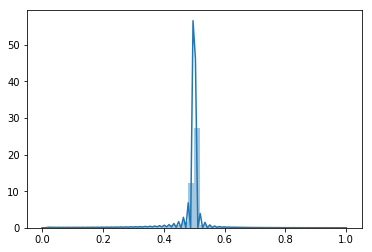

In [89]:
standard_scores = encoder.predict(x_test_scaled).ravel()
#regularized_scores = encoded_regularized.predict(x_test).ravel()
sns.distplot(standard_scores, hist=True, label='standard model')
#sns.distplot(regularized_scores, hist=False, label='regularized model')

In [79]:
# encode and decode some images
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test_min_max)
# decoded_imgs_scaled = decoder.predict(encoded_imgs)
#decoded_imgs_scaled = autoencoder.predict(x_test_min_max)
decoded_imgs_scaled = autoencoder.predict(x_test_scaled)
decoded_imgs = supermax*decoded_imgs_scaled
#decoded_imgs = min_max_scaler.inverse_transform(decoded_imgs_scaled)
#decoded_imgs = autoencoder.predict(x_test)


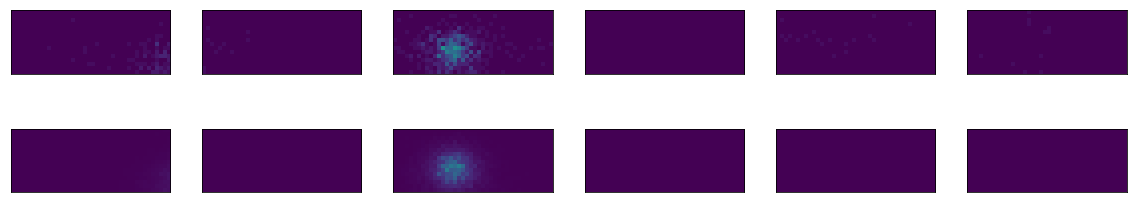

5448


In [80]:
n = 6  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(40, 16).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(40, 16).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)



In [81]:
import pandas as pd
filename = '../datos_octubre_2018/p_OF_5mm_161mm003.h5'
conjunto_datos_test=pd.read_hdf(filename,'MC');
conjunto_datos_test.shape

(6296, 3840)

In [82]:
L1A=6;
# hay tres L1 con 640 sensores (40*16)
L1B=0;
# hay dos L1 con 640 sensores (40*16)
X_trained=conjunto_datos_test.values;
x_trained=X_trained;

for i in range (X_trained.shape[0]):
    idea1=X_trained[i,:].reshape(img_rows,(L1A*img_cols));
    ideat=idea1.transpose();
    idea2=ideat.reshape(1,(L1A*img_cols)*img_rows);
    x_trained[i,:] =idea2;
x_tested = x_trained;
print(x_trained.shape)
print(x_tested.shape)

(6296, 3840)
(6296, 3840)


# Vamos a procesar y comprimir con la red

Ahora los particionamos y pasamos por las redes de compresión. Hay una red la A que se utiliza 5 veces

In [83]:

def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))

cara_externa=x_tested[:,0: L1A*input_output_dim_A] 
cara_externa_reconstruida=np.zeros((x_tested.shape[0],L1A*input_output_dim_A))
for i in range(x_tested.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_tested[i,k*input_output_dim_A:k*input_output_dim_A+input_output_dim_A]
    #ideaA_scaled=min_max_scaler.transform(ideaA)
    ideaA_scaled=ideaA/(supermax)
    salida_reconstructed_1_scaled = autoencoder.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*salida_reconstructed_1_scaled
    #salida_reconstructed_1 = min_max_scaler.inverse_transform(salida_reconstructed_1_scaled)     
    #salida_reconstructed_1 = ideaA
    
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
    #entrada_imgs_A=(ideaA) #he quitado el escalado
    #encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
    #decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
    #print(decoded_imgs_A.shape)
    #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
    #salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    
 
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))

    #print(hola.shape)
    salida_total=hola1
    #salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
  

## Visualizamos los resultados

Visualizamos todos los sensores: 

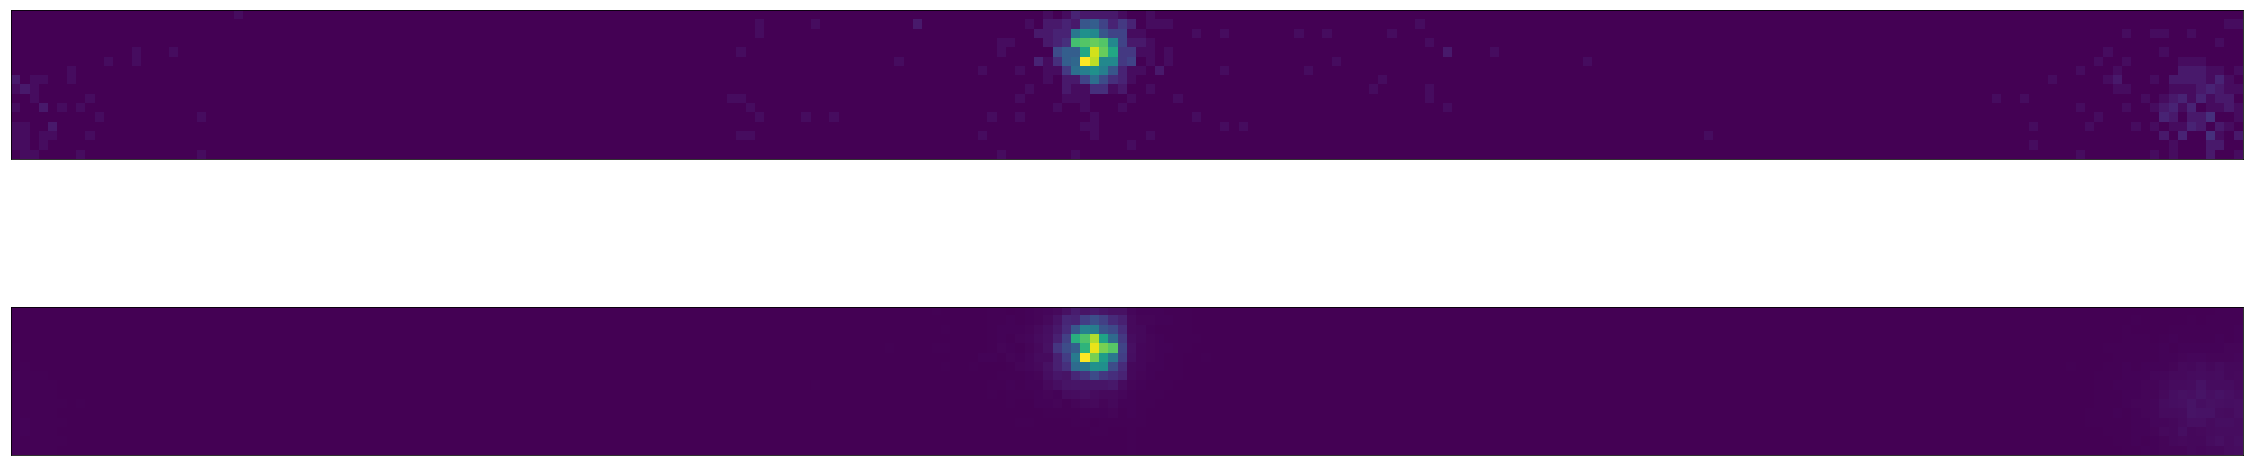

In [84]:
n = 1  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_tested.shape[0])
    idea=1890
    idea= 4299
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_cols, img_rows).transpose(), vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_cols, img_rows).transpose(), vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Visualizamos ahora L1 a L1, teniendo en cuenta que hay de dos tipos:
L1A (con 36 columnas )

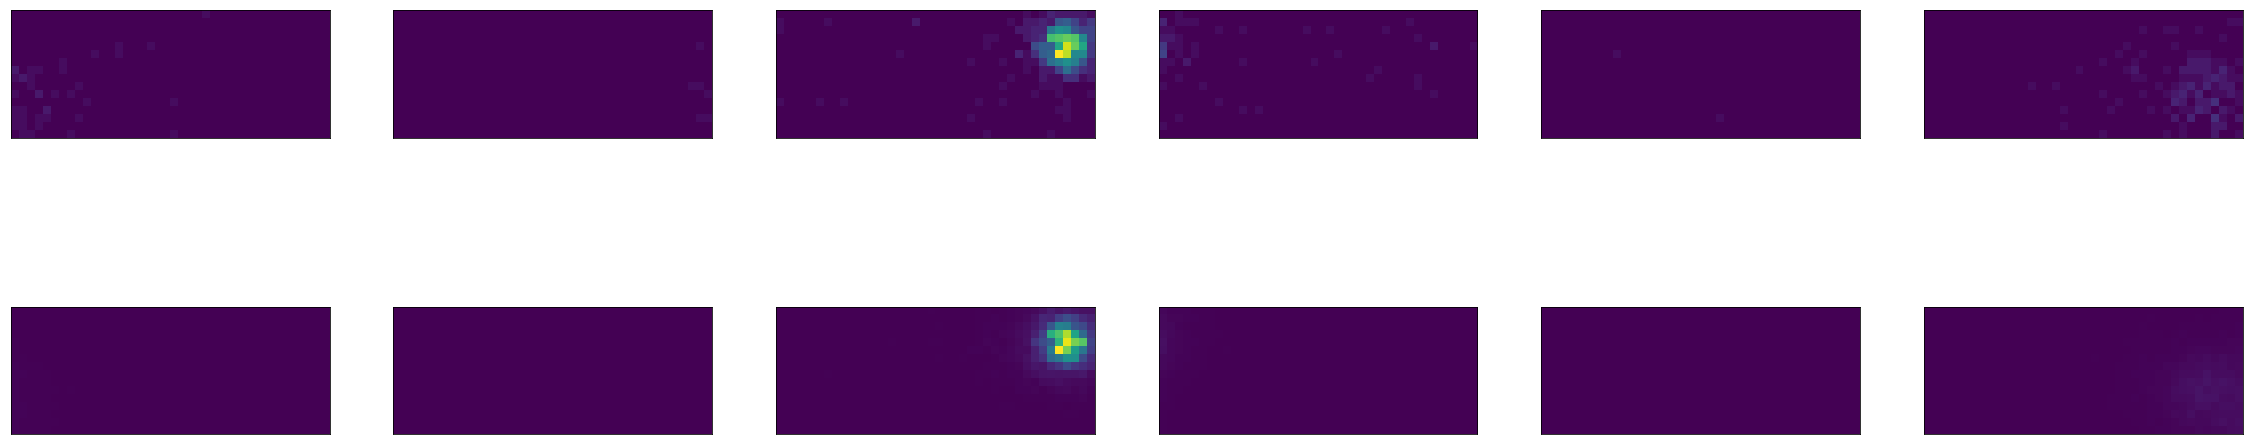

In [85]:
n = L1A  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_cols, img_rows).transpose()[:,i*img_cols:(i+1)*img_cols] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_cols, img_rows).transpose()[:,i*img_cols:(i+1)*img_cols] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [86]:
i=2
print(cara_externa[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:])
print(np.sum(cara_externa[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:]))

[[ 0  1  1  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0

In [87]:
print(cara_externa_reconstruida[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:].astype(int))
print(np.sum(cara_externa_reconstruida[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:]))

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0

In [88]:
print(idea)

4299
